# How does a bike-share navigate speedy success? 🚴‍♂️🚴🚴‍♀️

## Introduction🎬🚲
Cyclistic, a bike-share company, aims to understand how different types of users—annual members and casual riders—use their service. This analysis focuses on identifying usage patterns, preferences, and behavioral differences between these two groups. By using the provided dataset, we can uncover actionable insights that support targeted marketing and operational strategies to optimize Cyclistic's services.

The primary question this case study seeks to address is: How do annual members and casual riders use Cyclistic bikes differently?

The other two questions are:
Why would casual riders buy Cyclistic annual memberships?
How can Cyclistic use digital media to influence casual riders to become members?

Using visualizations, we analyze key trends such as ride frequency, duration, and time-based usage patterns. Each visualization is accompanied by an explanation of its purpose and refined observations derived from the analysis.

## Data Preparation 👨‍🍳
To begin the analysis, the first step involved loading the combined dataset containing ride data for a full year. The dataset was prepared by merging monthly ride data files into a single comprehensive file, ensuring all records were consolidated for analysis. This file, named combined_data.csv, was then loaded into a pandas DataFrame for further exploration and processing.
Dataset source: https://divvy-tripdata.s3.amazonaws.com/index.html

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the combined data
file_path = '/Users/aravindsankars/Documents/Case_Study_Cycles/dataset_prepare/combined_data.csv'
df = pd.read_csv(file_path)

print(df.head())
print(f"Combined dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

            ride_id  rideable_type           started_at             ended_at  \
0  743252713F32516B   classic_bike  2024-04-22 19:08:21  2024-04-22 19:12:56   
1  BE90D33D2240C614  electric_bike  2024-04-11 06:19:24  2024-04-11 06:22:21   
2  D47BBDDE7C40DD61   classic_bike  2024-04-20 11:13:13  2024-04-20 11:29:31   
3  6684E760BF9EA9B5   classic_bike  2024-04-04 18:39:20  2024-04-04 18:43:06   
4  CA9EFC0D24C24A27  electric_bike  2024-04-19 19:30:20  2024-04-19 20:07:42   

           start_station_name start_station_id  \
0  Aberdeen St & Jackson Blvd            13157   
1  Aberdeen St & Jackson Blvd            13157   
2  Sheridan Rd & Montrose Ave     TA1307000107   
3  Aberdeen St & Jackson Blvd            13157   
4  Sheridan Rd & Montrose Ave     TA1307000107   

                 end_station_name end_station_id  start_lat  start_lng  \
0    Desplaines St & Jackson Blvd          15539  41.877726 -87.654787   
1    Desplaines St & Jackson Blvd          15539  41.877722 -87.654959

## Data Cleaning and Feature Engineering 🧹
The next step in the analysis involved cleaning the dataset and engineering new features to derive meaningful insights.

#### Cleaning the DateTime Columns
**Remove Extra Characters:**
The started_at and ended_at columns were converted to datetime format using pd.to_datetime. Extra characters (e.g., fractions of a second) were removed to ensure consistency.

In [16]:
# Clean and convert the datetime columns
df['started_at'] = pd.to_datetime(df['started_at'].str.split('.').str[0], errors='coerce')  # Remove extra characters
df['ended_at'] = pd.to_datetime(df['ended_at'].str.split('.').str[0], errors='coerce')  # Remove extra characters

**Handle Missing or Invalid Values:**
Rows with missing or invalid values in the started_at or ended_at columns were dropped to maintain data integrity.

In [18]:
# Drop rows with invalid or missing datetime values
df = df.dropna(subset=['started_at', 'ended_at'])

#### Feature Engineering
**Ride Length:**
The duration of each ride was calculated in minutes and stored in a new column, ride_length.

**Day of the Week:**
The day of the week for each ride's start time was extracted and added as the day_of_week column.

**Hour of the Day:**
The hour when each ride started was extracted to analyze hourly trends. This was stored in the hour_of_day column.

In [20]:
# Add derived columns
df['ride_length'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60  # Ride length in minutes
df['day_of_week'] = df['started_at'].dt.day_name()  # Day of the week
df['hour_of_day'] = df['started_at'].dt.hour  # Hour of the day

#### Summary Table Creation
**Grouping and Aggregation:**
The data was grouped by member_casual, day_of_week, and hour_of_day to calculate metrics such as ride count and average ride length.

**Day Ordering:**
The day_of_week column was ordered to reflect the natural sequence of days from Sunday to Saturday.

In [22]:
# Summary grouping by member/casual, day of week, and hour of day
df_summary = df.groupby(['member_casual', 'day_of_week', 'hour_of_day'], as_index=False).agg(
    ride_count=('ride_id', 'count'),
    avg_ride_length=('ride_length', 'mean')
)

# Order days of the week
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
df_summary['day_of_week'] = pd.Categorical(df_summary['day_of_week'], categories=day_order, ordered=True)

# Aggregate data to include total rides, average ride length, most common day, and most common hour
rider_comparison = df.groupby('member_casual').agg(
    total_rides=('ride_id', 'count'),
    avg_ride_length=('ride_length', 'mean'),
    most_common_day=('day_of_week', lambda x: x.mode()[0] if not x.mode().empty else None),
    most_common_hour=('hour_of_day', lambda x: x.mode()[0] if not x.mode().empty else None)
).reset_index()

#### Rider Comparison Table
A high-level comparison between casual riders and members was created, summarizing:

- Total Rides: Number of rides taken by each group.
- Average Ride Length: Average duration of rides in minutes.
- Most Common Day: The day of the week with the highest number of rides.
- Most Common Hour: The hour of the day with the highest number of rides.

In [24]:
# Display the table
rider_comparison

,member_casual,total_rides,avg_ride_length,most_common_day,most_common_hour
0,casual,2151658,25.150669,Saturday,17
1,member,3708910,12.770208,Wednesday,17


### Insights
> <blockquote style="font-weight: bold; color: #000000;">
> **Casual Riders:**
> - Have significantly longer ride lengths, likely indicating recreational usage.
> - Prefer weekends (especially Saturday) and late afternoon hours (5 PM).
> </blockquote>
> <blockquote style="font-weight: bold; color: #000000;">
> **Members:**
> - Take shorter rides, aligning with regular commuting patterns.
> - Show higher activity during weekdays (especially Wednesday) at peak commuting times (5 PM).
> </blockquote>

Lets dive deeper and find out what differentiates the two groups of riders.

To maintain consistency in visualizations throughout the analysis, a uniform color palette is defined at the outset.

In [129]:
# Define a color palette for casual and member groups
colors = {'casual': '#e73924', 'member': '#1f77b4'}

## Visualization 📊
To gain actionable insights into the behavior and preferences of Cyclistic’s casual and member riders, we employ a series of targeted visualizations. These plots not only uncover patterns in ridership but also highlight key differences between the two groups. These visualizations collectively address the primary question: *How do annual members and casual riders use Cyclistic bikes differently?* 

### 1. Bar Chart: Total rides by day of the week
This plot provides an overview of ride activity across the week, highlighting peak days for both casual and member riders. It helps identify whether weekends or weekdays see higher ridership and how these patterns differ between the groups.

<Figure size 1200x600 with 0 Axes>

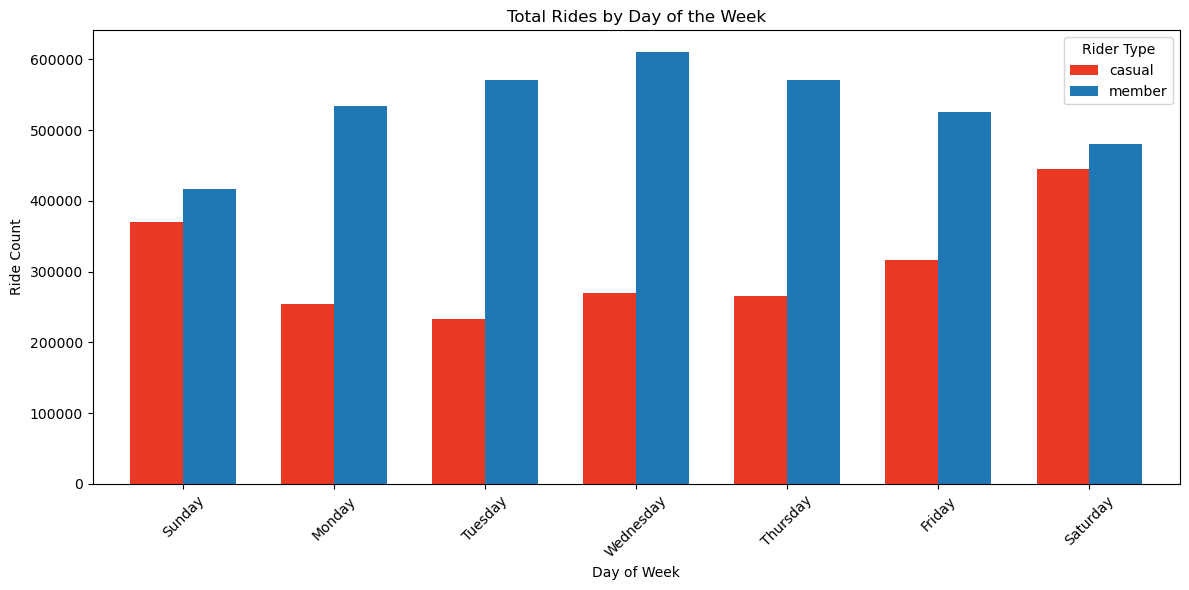

In [63]:
plt.figure(figsize=(12, 6))
bar_data = df.groupby(['day_of_week', 'member_casual'])['ride_id'].count().reset_index()
bar_data_pivot = bar_data.pivot(index='day_of_week', columns='member_casual', values='ride_id').reindex(day_order)
bar_data_pivot.plot(kind='bar', figsize=(12, 6), color=['#e73924', '#1f77b4'], width=0.7)
#1f77b4 #ff7f0e 
plt.title('Total Rides by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Ride Count')
plt.xticks(rotation=45)
plt.legend(title='Rider Type')
plt.tight_layout()
plt.show()

We can see that the ride counts are much higher for members than casuals with most of the rides happening during weekdays but evenly distributed for casuals on all days except on weekends where there is an increase.

> <blockquote style="font-weight: bold; color: #000000;">
> - **Members** exhibit higher ride counts on weekdays, with a clear drop during weekends
> - **Casual riders** maintain a relatively steady ride count across the week, with significant increases on weekends
> </blockquote>

This pattern enforces the idea that members primarily use bikes for work-related purposes, while casual riders use them for leisure activities.

### 2. Heatmap: Rides by hour of day vs. day of week
The heatmap visualizes ride activity over the course of the week and by hour of the day. This allows us to pinpoint peak usage times for casual and member riders, revealing patterns such as morning and evening commuting hours for members or recreational afternoon rides for casual riders.

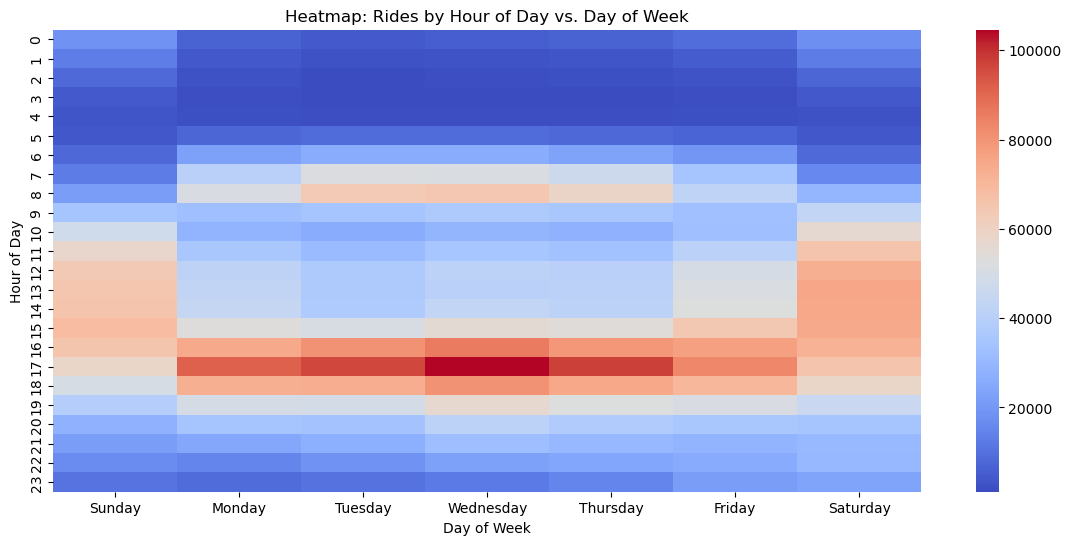

In [27]:
plt.figure(figsize=(14, 6))
heatmap_data = df_summary.pivot_table(
    index='hour_of_day', columns='day_of_week', values='ride_count', aggfunc='sum', observed=False
)
sns.heatmap(heatmap_data, cmap='coolwarm', annot=False)
plt.title('Heatmap: Rides by Hour of Day vs. Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.show()

As seen clearly in the heatmap, most rides happen on weekdays between 7-9AM and 3-7PM. We can safely assume that these are office timings and most of the customers use the cycles as commute to work. Additionally, on friday mornings, there are less rides while there are more in the evening. The peak hour is 3:30-5:30 pm on Mondays.

> <blockquote style="font-weight: bold; color: #000000;">
> - Most rides occur during weekdays between 7-9 AM and 3-7 PM, aligning with commuting hours
> - Friday mornings show reduced ride activity, with an increase in the evening andthrough weekend, potentially due to casual social outings
> - The highest peak is observed on Monday evenings (3:30–5:30 PM)
> </blockquote>

The number of rides of members and casuals differ and a lot as we have seen from the above rider_comparison table and from the bar plot. Hence, I might be able to get more insights if I analyze the casual riders and members differently.

#### Rides by hour of day vs. day of week for each group of members

Breaking down the heatmap by rider type allows us to uncover specific behavioral differences between casual riders and members.

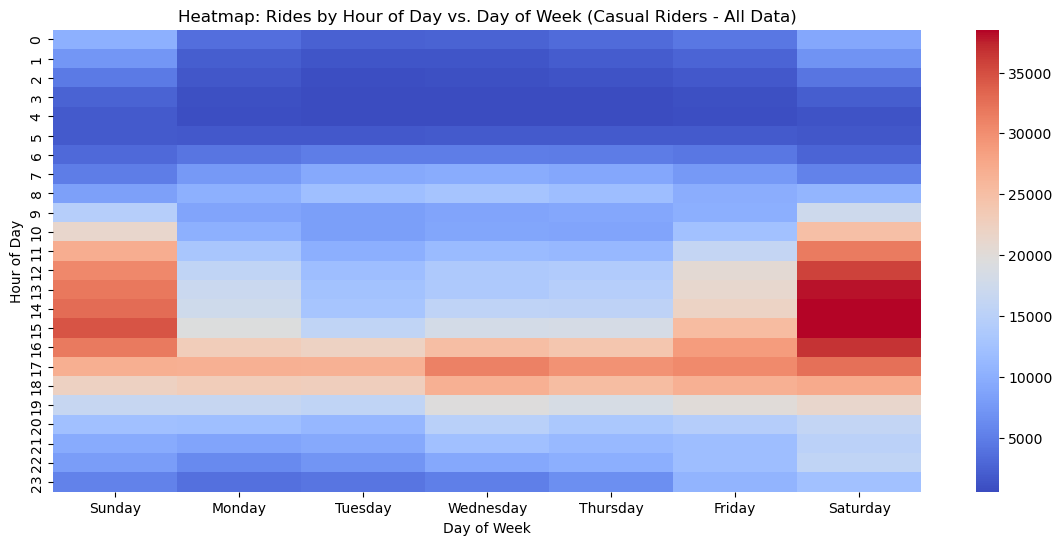

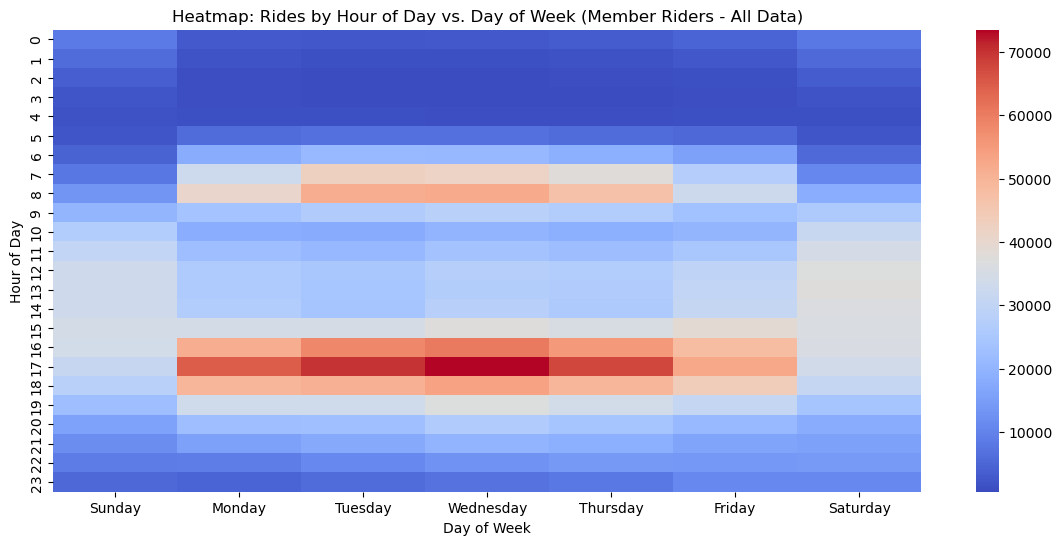

In [30]:
# Generate heatmaps for casual and member riders
def generate_heatmap_by_rider_type(df_summary, rider_type, title_suffix):
    # Filter data for the specific rider type
    df_filtered = df_summary[df_summary['member_casual'] == rider_type]
    
    # Pivot the data to create a heatmap-friendly format
    heatmap_data = df_filtered.pivot_table(
        index='hour_of_day', 
        columns='day_of_week', 
        values='ride_count', 
        aggfunc='sum', 
        observed=False
    )
    
    # Create the heatmap
    plt.figure(figsize=(14, 6))
    sns.heatmap(heatmap_data, cmap='coolwarm', annot=False, cbar=True)
    plt.title(f'Heatmap: Rides by Hour of Day vs. Day of Week ({rider_type.capitalize()} Riders - {title_suffix})')
    plt.xlabel('Day of Week')
    plt.ylabel('Hour of Day')
    plt.show()

# Generate heatmaps for casual and member riders
generate_heatmap_by_rider_type(df_summary, rider_type='casual', title_suffix='All Data')
generate_heatmap_by_rider_type(df_summary, rider_type='member', title_suffix='All Data')

When we analyze casual and members differently, we can see that members mostly use the cycles for office purposes(mornings and evenings on weekdays). Most number of casuals ride in the weekend(Saturday and Sunday) especially on Saturdays from 12PM to 5PM.

> <blockquote style="font-weight: bold; color: #000000;">
> - *Members*: Predominantly ride during weekday mornings and evenings, indicating usage for commuting.
> </blockquote>
> <blockquote style="font-weight: bold; color: #000000;">
> - *Casual Riders*: Primarily ride during weekends, with peak activity on Saturdays (12 PM–5 PM), suggesting recreational or leisure use.
> </blockquote>

### 3. Line Chart: Trends in total rides by hour of the day
By plotting the total number of rides for each hour of the day, we capture the daily ridership trends. This visualization helps to compare hourly usage patterns and highlights how casual and member riders utilize the service at different times of the day.

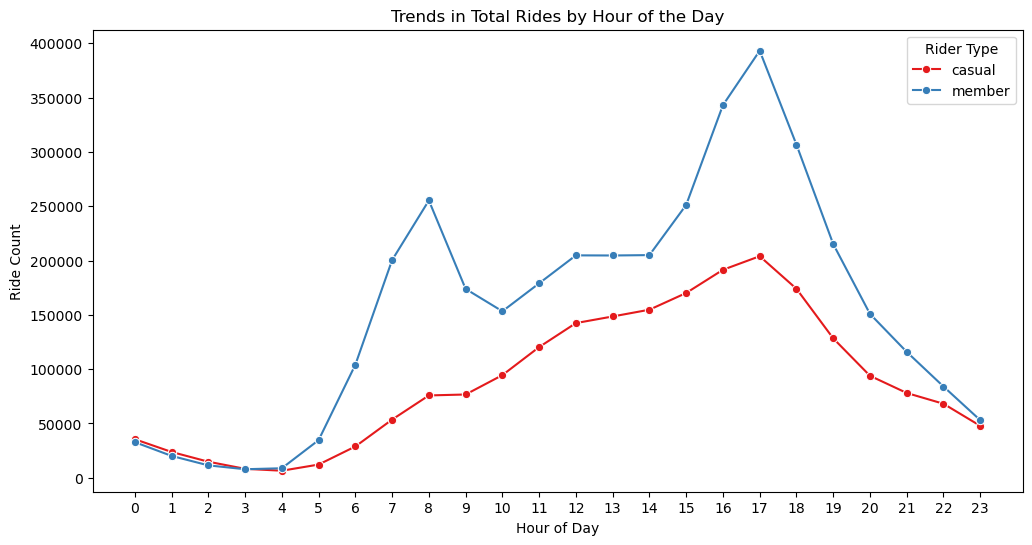

In [42]:
plt.figure(figsize=(12, 6))
line_data = df.groupby(['hour_of_day', 'member_casual'])['ride_id'].count().reset_index()
sns.lineplot(data=line_data, x='hour_of_day', y='ride_id', hue='member_casual', marker='o', palette='Set1')
plt.title('Trends in Total Rides by Hour of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Ride Count')
plt.xticks(range(0, 24))
plt.legend(title='Rider Type')
plt.show()

> <blockquote style="font-weight: bold; color: #000000;">
> - *Members* show distinct peaks during morning and evening hours, reinforcing commuting patterns.
> </blockquote>
> <blockquote style="font-weight: bold; color: #000000;">
> - *Casual* riders have a single gradual peak in the afternoon, which correlates with recreational activity.
> <blockquote>

### 4. Box Plot: Compare ride lengths for casuals vs. members
A box plot is used to explore the distribution of ride lengths for each rider type. It shows differences in ride duration and variability, illustrating that casual riders often have longer and more varied ride times compared to the consistent patterns of members.

**Cleaning ride_length column**

*Steps:*

- Check for and handle NaN values in the ride_length column
- Find maximum and minimum ride lengths in the dataset
- Ensure that ride_length is in a numeric format (e.g., float or integer). If it’s stored as a string, convert it to a numeric type
- Remove rides shorter than 1 minute and Cap the maximum ride length(removing outliers)
</blockquote>

In [297]:
# Check for null values
print(df['ride_length'].isnull().sum())

# Drop rows with NaN in ride_length
df = df.dropna(subset=['ride_length'])

# Convert ride_length to numeric (e.g., if stored as strings)
df['ride_length'] = pd.to_numeric(df['ride_length'], errors='coerce')

# Filter out invalid ride lengths
df = df[(df['ride_length'] >= 1) & (df['ride_length'] <= 70)]

0


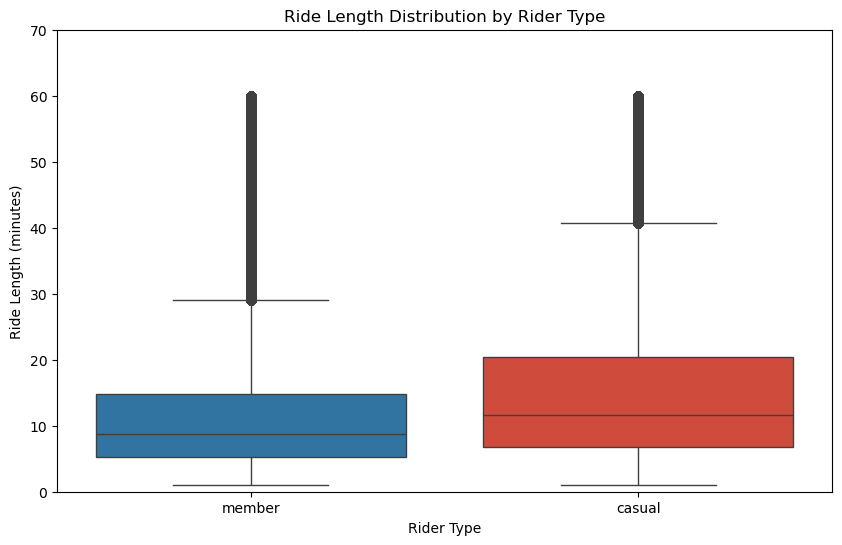

In [299]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='member_casual', y='ride_length', hue='member_casual', palette=colors, legend=False)
plt.title('Ride Length Distribution by Rider Type')
plt.xlabel('Rider Type')
plt.ylabel('Ride Length (minutes)')
plt.ylim(0, 70)
plt.show()

From this plot we can see that, casuals ride for more duration than members. There is more variability in ride lengths for casuals. The median of casuals is above 20 minutes and member is below 10 minutes.

> <blockquote style="font-weight: bold; color: #000000;">
> - *Casual Riders:*
> Tend to take longer rides with greater variability and many outliers.
> Likely use the service for leisure or recreation.
> </blockquote>

> <blockquote style="font-weight: bold; color: #000000;">
> - *Member Riders:*
> Have shorter and more consistent ride lengths.
> Primarily use the service for regular, utilitarian travel like commuting.
> </blockquote>

Casual riders tend to have significantly longer ride durations, with a median above 20 minutes, and show greater variability with numerous outliers.
Members have shorter and more consistent ride lengths, with a median below 10 minutes.

These differences align with the hypothesis that casual riders prioritize recreational trips, while members focus on efficiency.

### 5. Bar Plot: Ride length vs. hour of the day
This plot delves into the relationship between ride length and the hour of the day, segmented by rider type. It uncovers trends such as casual riders taking longer rides during non-peak hours, while members generally have shorter, consistent ride lengths.

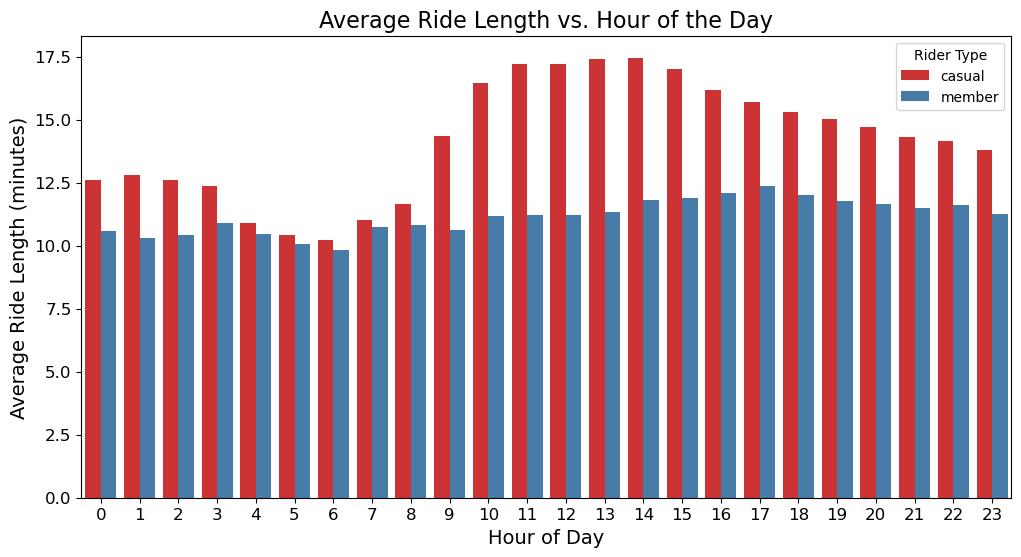

In [304]:
plt.figure(figsize=(12, 6))

# Plot a bar graph for average ride length by hour of day, grouped by rider type
sns.barplot(
    data=df,
    x='hour_of_day',
    y='ride_length',
    hue='member_casual',
    errorbar=None,
    palette='Set1'
)

# Add titles and labels
plt.title('Average Ride Length vs. Hour of the Day', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Average Ride Length (minutes)', fontsize=14)
plt.legend(title='Rider Type')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()


> <blockquote style="font-weight: bold; color: #000000;">
> - *Casual* riders consistently have longer ride durations throughout the day, with peaks in the afternoon and evening hours.
> </blockquote>
> <blockquote style="font-weight: bold; color: #000000;">
> - *Members* maintain relatively stable ride lengths, suggesting consistent usage patterns.
> </blockquote>

There is a dip in the duration in the late night and early morning hours for casual members. The early morning casuals have the lowest ride lengths and this suggests that these casuals might be using it for commute purposes like going to their gym in the early morning. These people have the most probability of converting to annual members.

### Bucketize based on time of day 🪣
Categorize rides into time periods (Morning, Afternoon, Evening, Night) to analyze patterns in conjunction with rider type and day of the week.

- Categorized hours of the day into four time buckets.
- Grouped data by member_casual, day_of_week, and time_of_day.
- Created heatmaps to visualize:
    - Total rides per time of day and day of week.
    - Average ride length per time of day and day of week.

In [88]:
# Define hour categories
def categorize_hour(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# Add a new column for time categories
df['time_of_day'] = df['hour_of_day'].apply(categorize_hour)

# Set the order for time_of_day
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']
df['time_of_day'] = pd.Categorical(df['time_of_day'], categories=time_order, ordered=True)

# Analyze by time of day, day of the week, and rider type
time_analysis = df.groupby(['member_casual', 'day_of_week', 'time_of_day'], observed=False).agg(
    total_rides=('ride_id', 'count'),
    avg_ride_length=('ride_length', 'mean')
).reset_index()

# Order the day_of_week column
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
time_analysis['day_of_week'] = pd.Categorical(time_analysis['day_of_week'], categories=day_order, ordered=True)

# Sort the results for better readability
time_analysis.sort_values(by=['member_casual', 'day_of_week', 'time_of_day'], inplace=True)


#### Total Rides Heatmap
The heatmaps for total rides provide a detailed view of ride activity patterns for casual and member riders based on the time of day and day of the week.

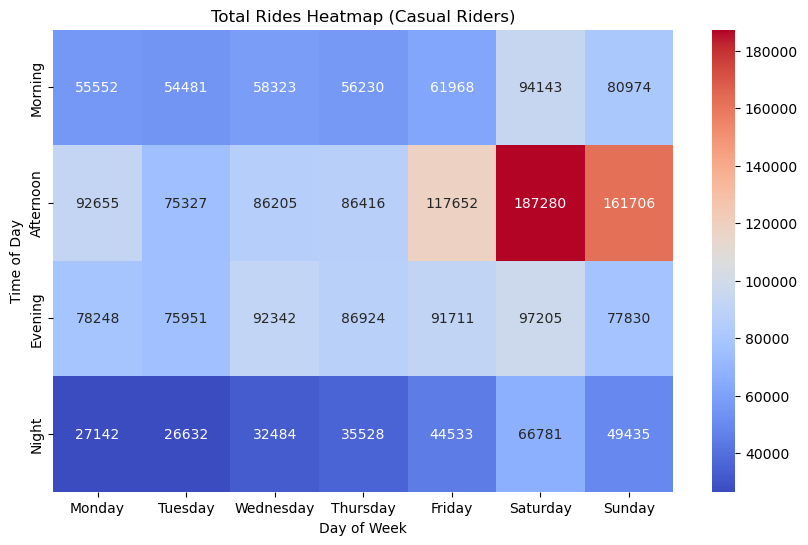

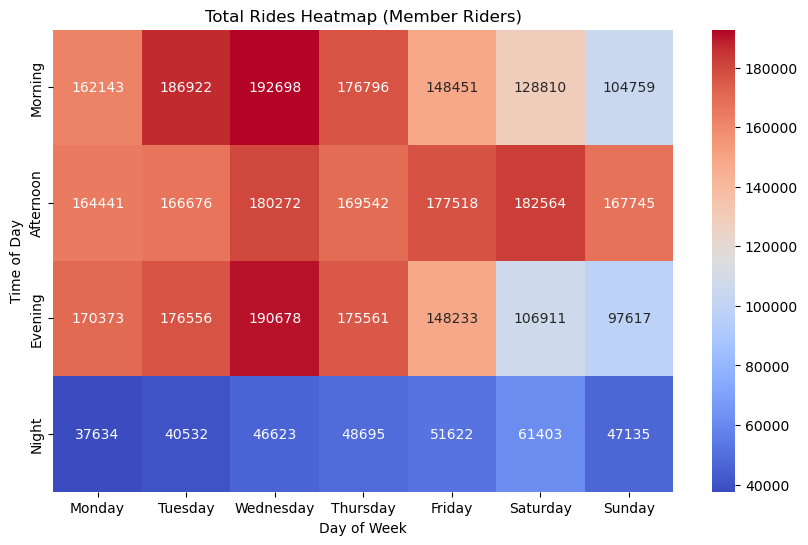

In [84]:
# Create a heatmap to visualize total rides by day of week and time of day for each rider type
for rider_type in ['casual', 'member']:
    heatmap_data = time_analysis[time_analysis['member_casual'] == rider_type].pivot(
        index='time_of_day', columns='day_of_week', values='total_rides'
    )
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='coolwarm', cbar=True)
    plt.title(f'Total Rides Heatmap ({rider_type.capitalize()} Riders)')
    plt.xlabel('Day of Week')
    plt.ylabel('Time of Day')
    plt.show()

#### Average Ride Length Heatmap
The heatmaps for average ride length reveal additional insights into the nature of trips for each rider type.

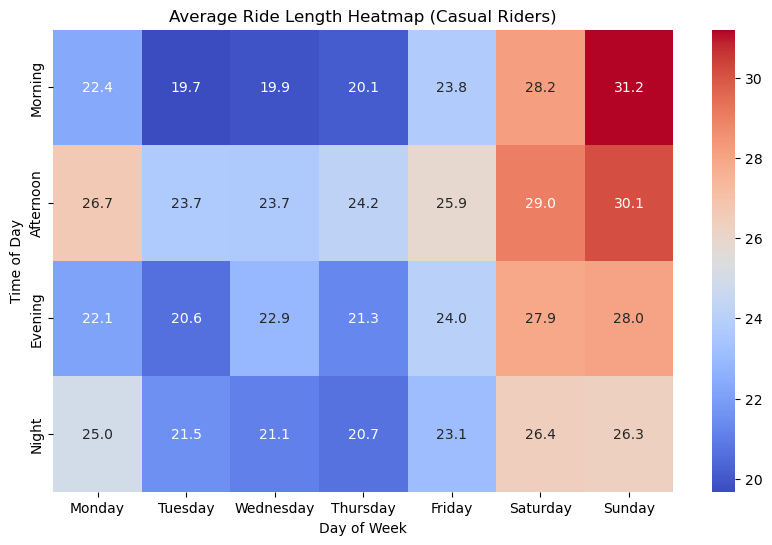

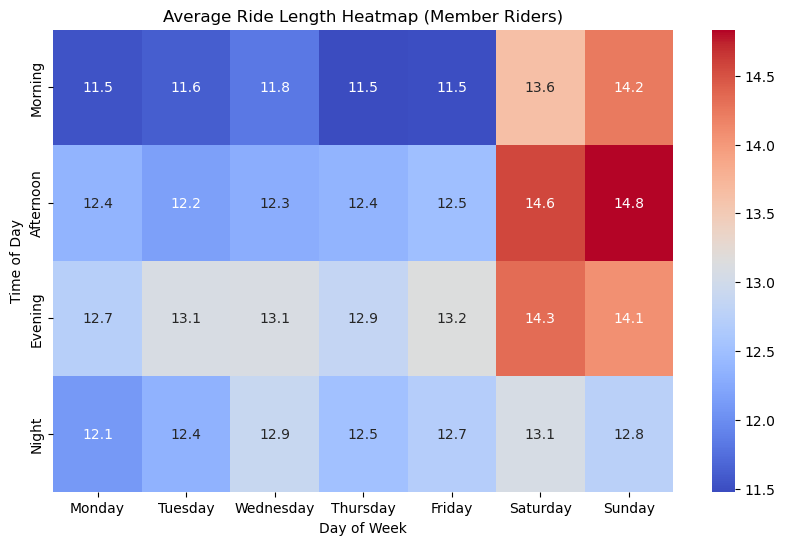

In [86]:
# Create a heatmap to visualize average ride length by day of week and time of day for each rider type
for rider_type in ['casual', 'member']:
    heatmap_data = time_analysis[time_analysis['member_casual'] == rider_type].pivot(
        index='time_of_day', columns='day_of_week', values='avg_ride_length'
    )
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='coolwarm', cbar=True)
    plt.title(f'Average Ride Length Heatmap ({rider_type.capitalize()} Riders)')
    plt.xlabel('Day of Week')
    plt.ylabel('Time of Day')
    plt.show()

#### Observations:
**Casual Riders:**
- Prefer afternoons and evenings, especially on weekends.
- Tend to have longer average ride lengths during non-peak hours, aligning with recreational usage.

**Member Riders:**
- High activity during mornings and evenings on weekdays, consistent with commute times.
- Show shorter, more efficient rides compared to casual riders.

Now, lets uncover seasonal usage trends and compare how casual and member riders adapt their riding habits throughout the year.

### Monthly Analysis: Seasonal Trends in Ridership and Ride Length
To better understand how seasonal changes influence rider behavior, we analyzed ridership trends and ride lengths across the months, focusing on differences between casual and member riders.

**Data Preparation:**
- Extracted the month from the ride start times and arranged them chronologically for clear visualization.
- Grouped the data by rider type (member_casual) and month to calculate total rides and average ride lengths.

**Visualizations:**
- A bar plot was created to showcase the total rides per month, highlighting seasonal fluctuations in ridership patterns for casual and member riders.
- Another bar plot was used to display the average ride length per month, providing insights into how trip durations vary with the seasons for each rider type.

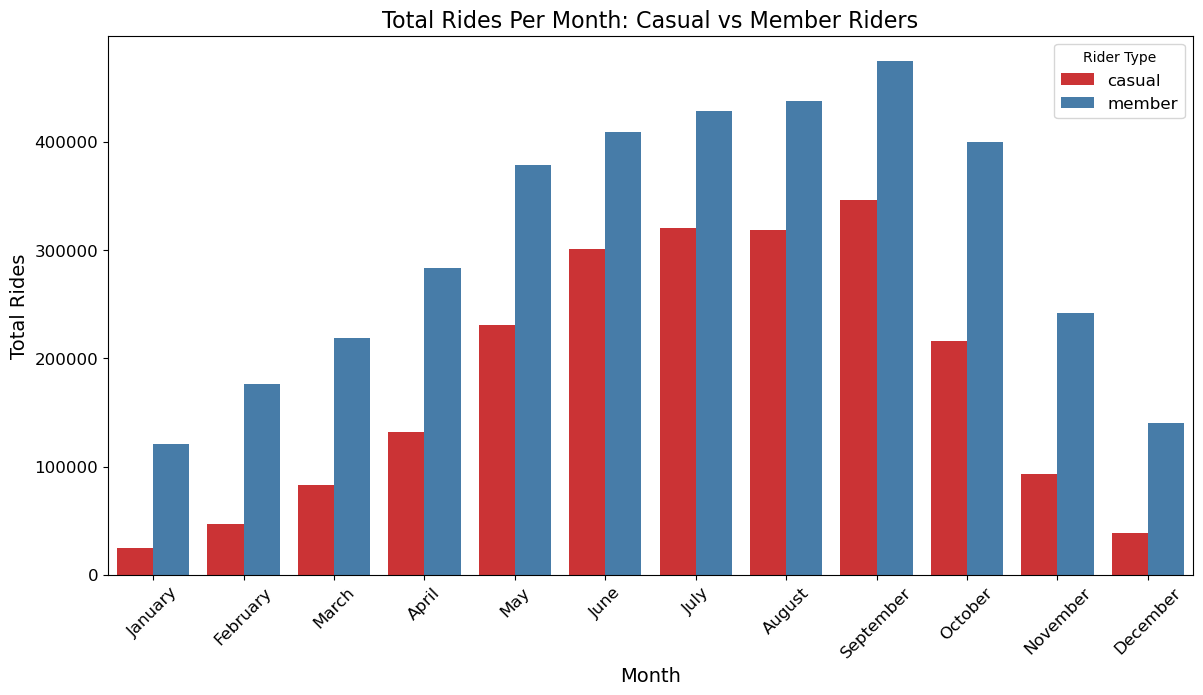

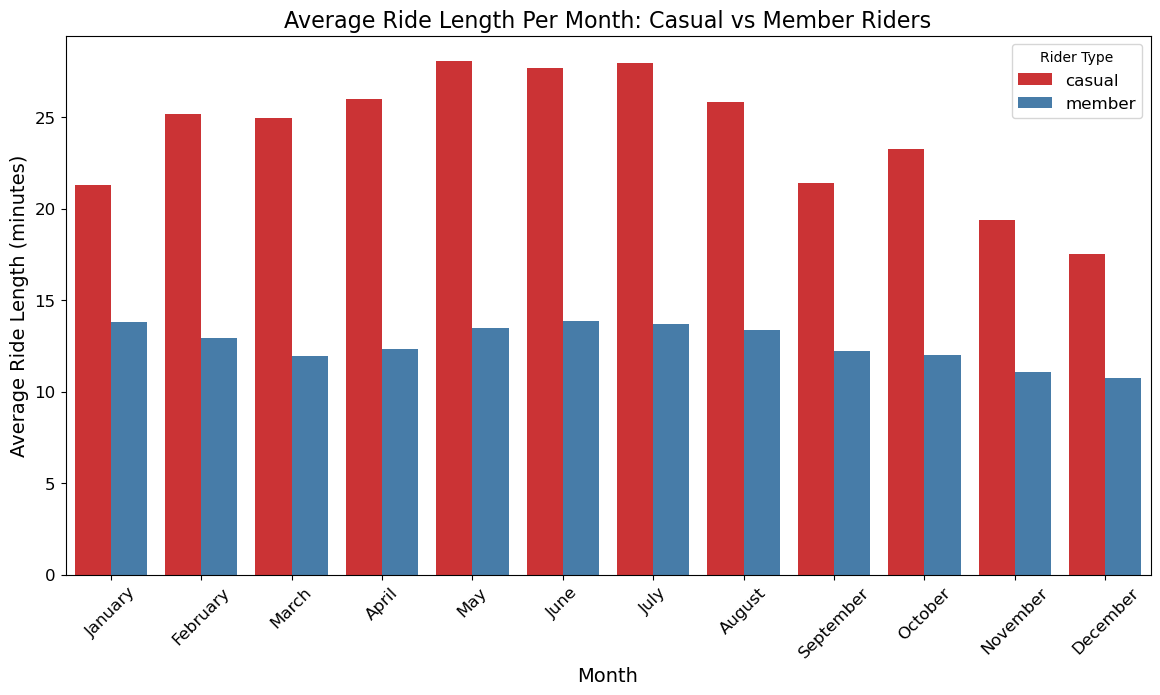

In [60]:
# Extract month from the started_at column
df['month'] = df['started_at'].dt.month_name()

# Order months chronologically for better visualization
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

# Group by rider type and month to calculate total rides and average ride length
monthly_summary = df.groupby(['member_casual', 'month']).agg(
    total_rides=('ride_id', 'count'),
    avg_ride_length=('ride_length', 'mean')
).reset_index()

# Ensure months are ordered correctly
monthly_summary['month'] = pd.Categorical(monthly_summary['month'], categories=month_order, ordered=True)
monthly_summary = monthly_summary.sort_values('month')

# Plot total rides per month
plt.figure(figsize=(14, 7))
sns.barplot(
    data=monthly_summary,
    x='month',
    y='total_rides',
    hue='member_casual',
    palette='Set1'
)
plt.title('Total Rides Per Month: Casual vs Member Riders', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Rides', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Rider Type', fontsize=12)
plt.show()

# Plot average ride length per month
plt.figure(figsize=(14, 7))
sns.barplot(
    data=monthly_summary,
    x='month',
    y='avg_ride_length',
    hue='member_casual',
    palette='Set1'
)
plt.title('Average Ride Length Per Month: Casual vs Member Riders', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Ride Length (minutes)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Rider Type', fontsize=12)
plt.show()

#### Observations:
**Casual Riders:**
- Activity peaks during summer months (June–August), reflecting seasonal leisure usage.
- Ride lengths are generally longer, showing variability based on weather and events.

**Member Riders:**
- Maintain steady activity throughout the year, indicating consistent commuting patterns.
- Ride lengths are shorter and more uniform, emphasizing efficiency and purpose.

## Final Observations: 🕵️
**1. Time-of-Day Analysis**
- Casual riders prefer afternoons and evenings, with weekends (Saturday and Sunday) showing the highest activity.
- Member ridership peaks in the mornings and evenings on weekdays, consistent with typical work commute patterns.
The heatmaps highlight that both rider types have distinct preferences in terms of time of day and day of the week.

**2. Ride Length Distribution**
- Casual riders generally have longer ride lengths compared to members, with many rides exceeding 30 minutes.
- Member riders have shorter, more uniform ride durations, aligning with routine travel needs.
The ride length distribution indicates casual riders utilize the service more for recreation, while members are focused on efficiency.

**3. Peak vs Non-Peak Hour Analysis**
- Casual riders dominate during non-peak hours, likely due to flexible schedules or recreational use.
- Members primarily use the service during peak hours, indicating routine commuting.
Average ride length during non-peak hours is significantly higher for casual riders, suggesting leisurely rides.

**4. Behavioral Analysis by Month**
- Casual riders exhibit higher variability in ride activity across the months, likely influenced by seasonal trends and leisure preferences.
- Member riders show consistent ride activity throughout the year, reflecting regular commuting patterns.
The bar plots reveal that summer months (June–August) are peak periods for casual riders, while member ridership remains steady.

> <blockquote style="font-weight: bold; color: #000000;">
> ### Key Insights:

> **Differentiated Usage Patterns**

> #### Casual Riders:
> Casual riders primarily use Cyclistic bikes for recreational purposes during weekends, afternoons, and evenings. Their ride lengths are often longer, suggesting leisurely activities like sightseeing or social outings.


**Notable Exception:** A subset of casual riders demonstrates behavior similar to members during early morning hours, with ride lengths matching those of members. This suggests short commutes, possibly to the gym or work.

> #### Members:
> Members exhibit consistent usage patterns aligned with workday commutes, peaking during weekday mornings and evenings. Their shorter and more uniform ride lengths reflect an emphasis on routine, efficiency, and reliability.
> </blockquote>

### Opportunities to Convert Casual Riders
**1. Target Casual Riders with Member-like Patterns**

- Casual riders with behavior resembling members (e.g., short morning commutes) represent a promising segment for membership conversion.
- Cyclistic could promote membership benefits to these riders, highlighting cost savings for frequent short trips and perks like priority access during peak hours.
  
**2. Seasonal Campaigns for Recreational Riders**

- Since casual ridership spikes during summer months (June–August), targeted campaigns emphasizing unlimited rides and reduced costs for longer trips could appeal to recreational users.

**3. Highlight Convenience and Value**

- Many casual riders may not realize the cost-effectiveness of annual memberships. Cyclistic can create digital media campaigns showcasing how frequent casual rides accumulate costs compared to a fixed annual fee.

### Recommendations for Digital Media Strategy
**1. Personalized Campaigns**

- Use rider data analytics to identify casual riders with consistent usage patterns.
- Send personalized emails or app notifications emphasizing membership value, tailored to individual habits (e.g., “Ride more like a pro! Save on your weekly morning rides.”).

**2. Social Proof and Testimonials**

- Share testimonials from current members who started as casual riders but found membership beneficial for daily routines or recreational activities.

**3. Promotions and Incentives**

- Offer limited-time discounts or perks for casual riders to try memberships, particularly during the summer months.
- Bundle memberships with additional perks (e.g., discounts at gyms, cafes, or attractions near high-activity zones).

**4. Engage Through Interactive Content**

- Use social media platforms with engaging content like polls (“How much do you save as a Cyclistic member?”) and challenges (e.g., “Ride to 10 destinations this month as a member to win prizes!”).

## Conclusion 🏁🚲
By targeting casual riders who exhibit consistent behaviors similar to members, emphasizing the financial and convenience benefits of memberships, and creating tailored digital campaigns, Cyclistic can effectively convert casual riders into loyal annual members. Additionally, using data insights to address specific use cases, such as short commutes during mornings or recreational rides during summer, will strengthen engagement and drive membership growth.